<a href="https://colab.research.google.com/github/gobeomgyu/deeplearning/blob/main/AI-learning%202/WISDM_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --------------------------------------------------------------------
# 0) 데이터 로드
# --------------------------------------------------------------------
path = '/content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt'

df = pd.read_csv(
    path,
    sep=',',
    engine='python',
    header=None,
    names=['user_id','activity','timestamp','x','y','z'],
    on_bad_lines='skip'
)

In [17]:
# 공백/세미콜론 정리
df['activity'] = df['activity'].astype(str).str.strip()
for c in ['x','y','z']:
    df[c] = (df[c].astype(str).str.strip().str.rstrip(';').replace('', pd.NA)).astype('float32')

#널값 제거
df = df.dropna()

# 결측치 제거
df = df.dropna(subset=['user_id','activity','timestamp','x','y','z'])

# timestamp 제거
df = df.drop(columns=['timestamp'])

# 형변환 & 정렬
df = df.astype({'user_id':'int64'})
df = df.sort_values(['user_id']).reset_index(drop=True)
print("데이터 로드 완료:", df.shape)
print(df.head())

데이터 로드 완료: (1086465, 5)
   user_id activity     x      y     z
0        1  Walking -1.53  19.34 -2.14
1        1  Walking -0.65   9.47 -1.80
2        1  Walking -4.44  11.37  0.11
3        1  Walking -6.82  10.12 -4.21
4        1  Walking -2.30  15.66 -1.46


■ df.shape: (1086465, 6)

■ df.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086465 entries, 0 to 1086464
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   user_id   1086465 non-null  int64  
 1   activity  1086465 non-null  object 
 2   x         1086465 non-null  float32
 3   y         1086465 non-null  float32
 4   z         1086465 non-null  float32
 5   label     1086465 non-null  int64  
dtypes: float32(3), int64(2), object(1)
memory usage: 37.3+ MB
None

■ 수치형 요약 통계:
            user_id             x             y             z         label
count  1.086465e+06  1.086465e+06  1.086465e+06  1.086465e+06  1.086465e+06
mean   1.883756e+01  6.641131e-01  7.246046e+00  3.976974e-01  2.931476e+00
std    1.026681e+01  6.873435e+00  6.738063e+00  4.759693e+00  1.942813e+00
min    1.000000e+00 -1.961000e+01 -1.961000e+01 -1.980000e+01  0.000000e+00
25%    1.000000e+01 -2.910000e+00  3.170000e+00 -2.220117e+

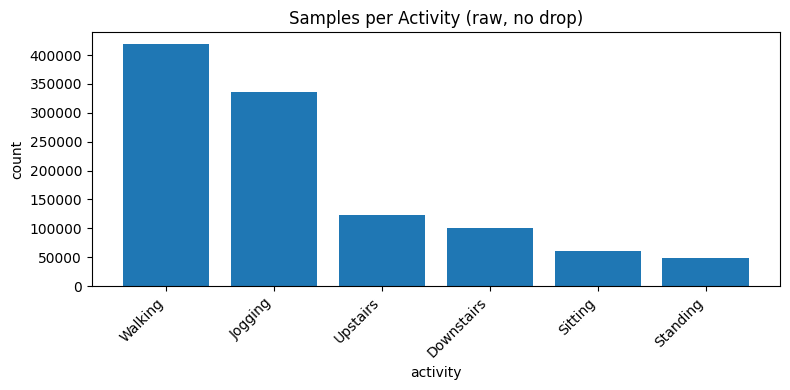

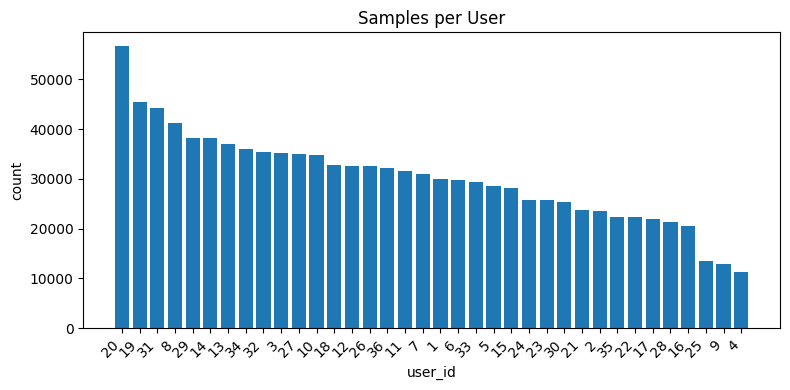

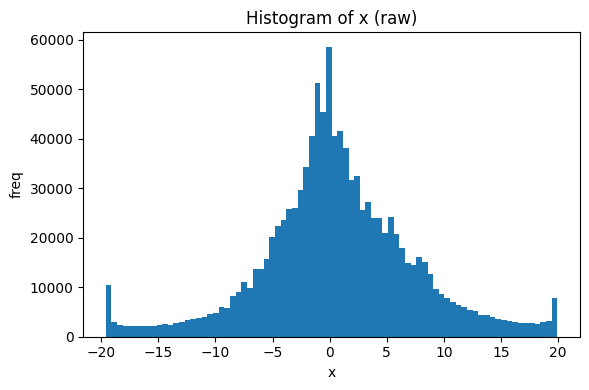

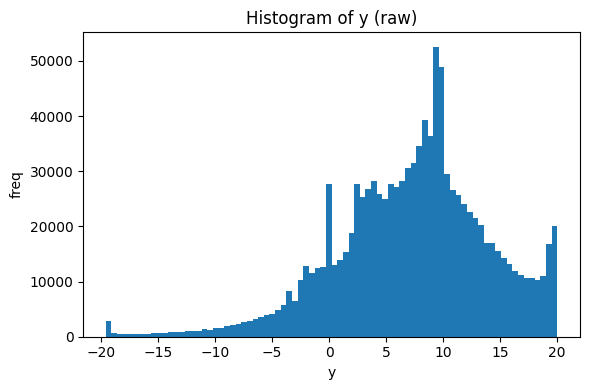

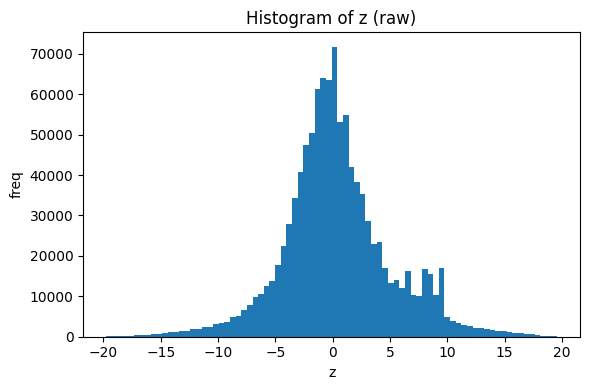

/tmp/ipython-input-3443802941.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


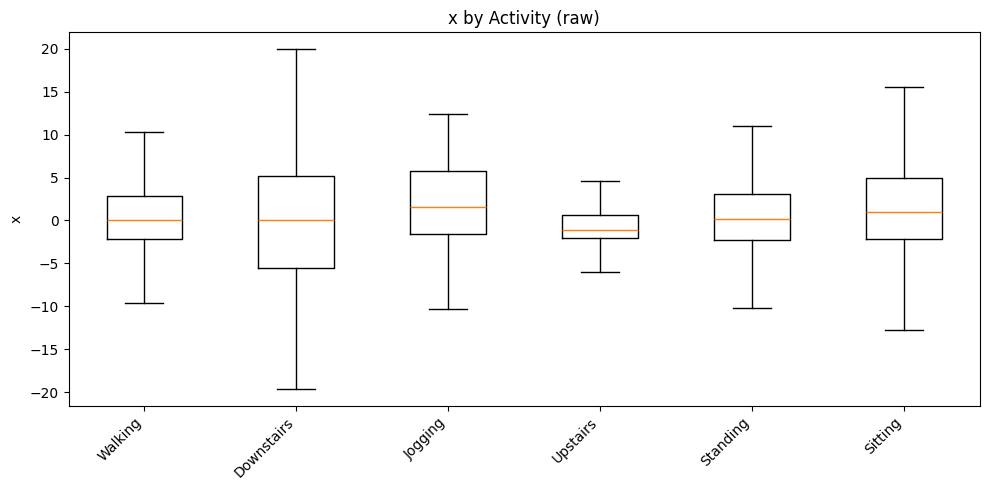

/tmp/ipython-input-3443802941.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


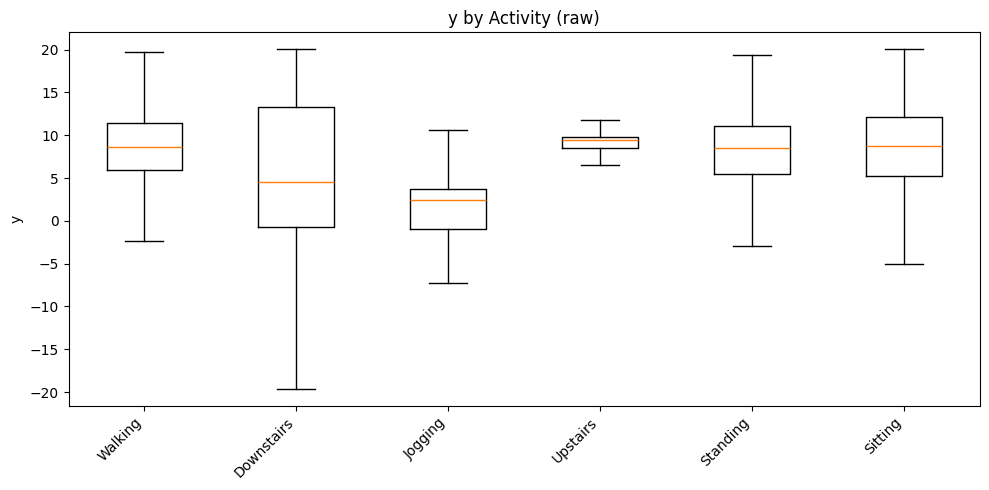

/tmp/ipython-input-3443802941.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


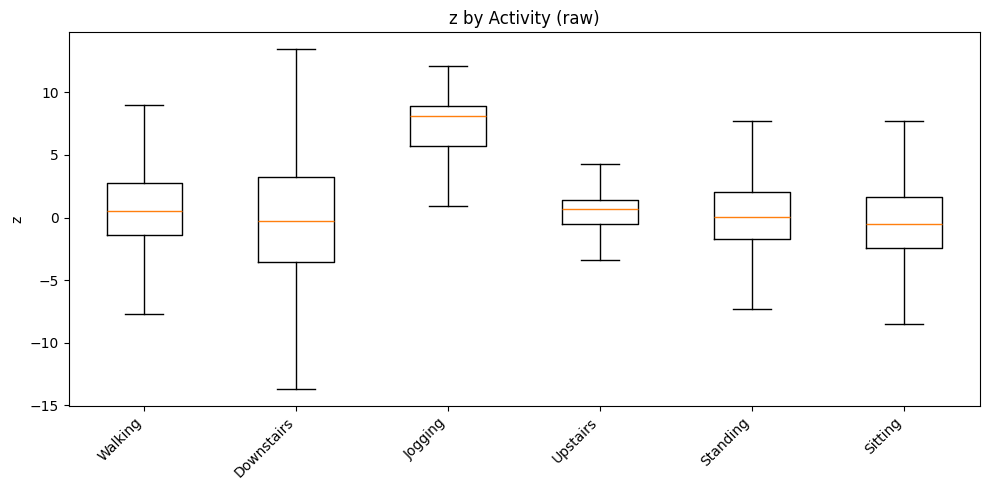

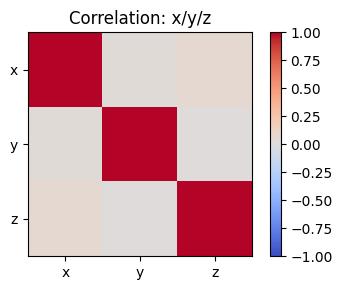

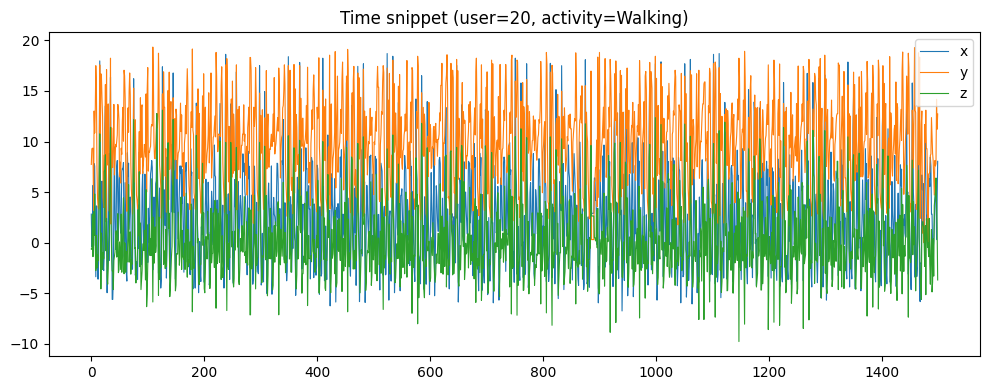

In [12]:
# === EDA 1: 기본 구조/결측/요약 ===
print("■ df.shape:", df.shape)
print("\n■ df.info():")
print(df.info())
print("\n■ 수치형 요약 통계:")
print(df.describe())

print("\n■ 결측치 개수:")
print(df.isnull().sum())

# 활동/사용자 분포
act_counts = df['activity'].value_counts()
user_counts = df['user_id'].value_counts()
print("\n■ 활동별 개수:\n", act_counts)
print("\n■ 사용자별 개수(상위 20):\n", user_counts.head(20))

# 바 차트 (활동)
plt.figure(figsize=(8,4))
plt.bar(act_counts.index.astype(str), act_counts.values)
plt.title("Samples per Activity (raw, no drop)")
plt.xlabel("activity"); plt.ylabel("count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()

# 바 차트 (사용자)
plt.figure(figsize=(8,4))
plt.bar(user_counts.index.astype(str), user_counts.values)
plt.title("Samples per User")
plt.xlabel("user_id"); plt.ylabel("count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()

# 축 별 히스토그램
for col in ['x','y','z']:
    plt.figure(figsize=(6,4))
    plt.hist(df[col].values, bins=80)
    plt.title(f"Histogram of {col} (raw)")
    plt.xlabel(col); plt.ylabel("freq")
    plt.tight_layout(); plt.show()

# 활동별 박스플롯 (x,y,z 각각)
for col in ['x','y','z']:
    groups = [g[col].dropna().values for _, g in df.groupby('activity')]
    labels = [str(a) for a in df['activity'].unique()]
    plt.figure(figsize=(10,5))
    plt.boxplot(groups, labels=labels, showfliers=False)
    plt.title(f"{col} by Activity (raw)")
    plt.xticks(rotation=45, ha="right"); plt.ylabel(col)
    plt.tight_layout(); plt.show()

# 상관관계 (x,y,z)
import numpy as np
num = df[['x','y','z']].astype('float32')
corr = np.corrcoef([num['x'], num['y'], num['z']])
plt.figure(figsize=(4,3))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(); plt.title("Correlation: x/y/z")
plt.xticks([0,1,2], ['x','y','z']); plt.yticks([0,1,2], ['x','y','z'])
plt.tight_layout(); plt.show()

# 간단한 시계열 단면(한 사용자, 한 활동) 미리보기
sample_user = int(df['user_id'].mode()[0])      # 가장 흔한 사용자
sample_act  = df['activity'].mode()[0]          # 가장 흔한 활동
sub = df[(df['user_id']==sample_user) & (df['activity']==sample_act)].head(1500)
plt.figure(figsize=(10,4))
plt.plot(sub['x'].values, linewidth=0.8, label='x')
plt.plot(sub['y'].values, linewidth=0.8, label='y')
plt.plot(sub['z'].values, linewidth=0.8, label='z')
plt.title(f"Time snippet (user={sample_user}, activity={sample_act})")
plt.legend(); plt.tight_layout(); plt.show()


In [18]:
# 1) 라벨 인코딩
# --------------------------------------------------------------------
le = LabelEncoder()
df['label'] = le.fit_transform(df['activity'])
print("라벨 매핑:", dict(zip(le.transform(le.classes_), le.classes_)))

라벨 매핑: {np.int64(0): 'Downstairs', np.int64(1): 'Jogging', np.int64(2): 'Sitting', np.int64(3): 'Standing', np.int64(4): 'Upstairs', np.int64(5): 'Walking'}


In [6]:
# 2) 사용자 기반 분할 (1~30 train, 31~33 val, 34~36 test)
# --------------------------------------------------------------------
users = sorted(df['user_id'].unique().tolist())
train_users = [u for u in users if 1 <= u <= 30]
val_users   = [u for u in users if 31 <= u <= 33]
test_users  = [u for u in users if 34 <= u <= 36]

df_train = df[df['user_id'].isin(train_users)].copy()
df_val   = df[df['user_id'].isin(val_users)].copy()
df_test  = df[df['user_id'].isin(test_users)].copy()

# 만약 일부 세트가 비면 → 시간 분할로 대체
def fallback_time_split(_df):
    cut1 = int(len(_df)*0.70); cut2 = int(len(_df)*0.85)
    return _df.iloc[:cut1].copy(), _df.iloc[cut1:cut2].copy(), _df.iloc[cut2:].copy()

if len(df_train)==0 or len(df_val)==0 or len(df_test)==0:
    print("[알림] 사용자 분할 불가 → 시간 기반 분할로 대체")
    df_train, df_val, df_test = fallback_time_split(df)

print("분할 크기:", len(df_train), len(df_val), len(df_test))


분할 크기: 886622 109241 90602


In [7]:
# 3) 스케일링 (train으로만 fit)
# --------------------------------------------------------------------
scaler = StandardScaler()
scaler.fit(df_train[['x','y','z']].values)
for part in [df_train, df_val, df_test]:
    part[['x','y','z']] = scaler.transform(part[['x','y','z']].values)


[TRAIN] 활동 분포:
 activity
Walking       347504
Jogging       269708
Upstairs      102810
Downstairs     82632
Sitting        45810
Standing       38158
Name: count, dtype: int64


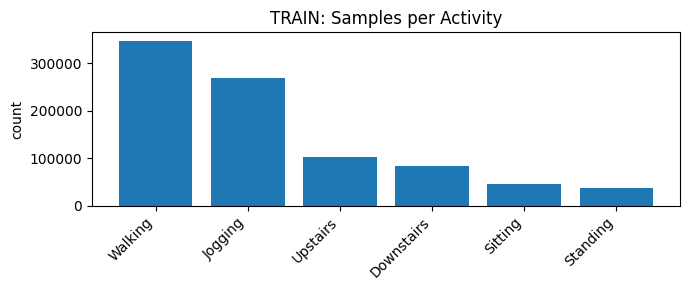


[VAL] 활동 분포:
 activity
Walking       44150
Jogging       29266
Downstairs    10770
Upstairs      10707
Sitting        8455
Standing       5893
Name: count, dtype: int64


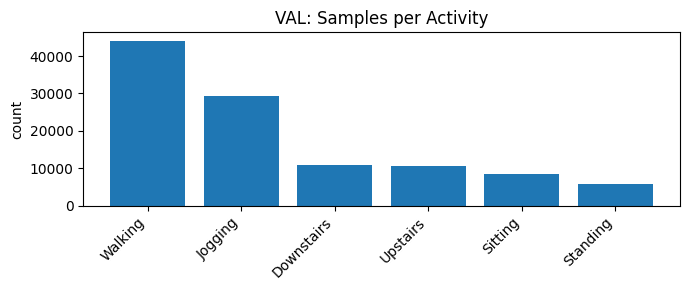


[TEST] 활동 분포:
 activity
Jogging       37471
Walking       26739
Upstairs       9352
Downstairs     7023
Sitting        5674
Standing       4343
Name: count, dtype: int64


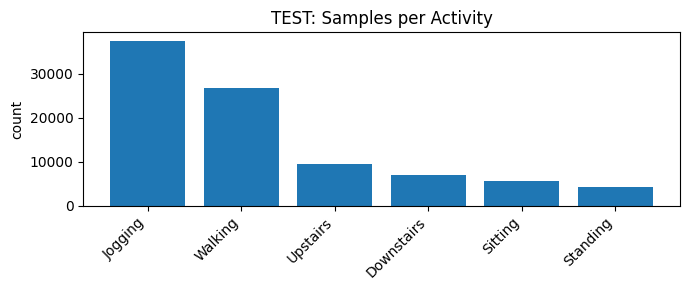

In [13]:
#라벨 불균형/ 유저 분할 확인
def show_split_distribution(name, part_df):
    vc = part_df['activity'].value_counts()
    print(f"\n[{name}] 활동 분포:\n", vc)
    plt.figure(figsize=(7,3))
    plt.bar(vc.index.astype(str), vc.values)
    plt.title(f"{name}: Samples per Activity")
    plt.xticks(rotation=45, ha='right'); plt.ylabel('count')
    plt.tight_layout(); plt.show()

show_split_distribution("TRAIN", df_train)
show_split_distribution("VAL", df_val)
show_split_distribution("TEST", df_test)


In [8]:
# 4) 윈도우 생성
# --------------------------------------------------------------------
def make_windows(part_df, WINDOW_SIZE=128, STEP=32, require_single_label=True):
    X, y = [], []
    for (uid, act), g in part_df.groupby(['user_id','activity'], sort=False):
        xs = g[['x','y','z']].values
        ys = g['label'].values
        i = 0
        while i + WINDOW_SIZE <= len(g):
            seg_x = xs[i:i+WINDOW_SIZE]
            seg_y = ys[i:i+WINDOW_SIZE]
            if (not require_single_label) or np.all(seg_y == seg_y[0]):
                X.append(seg_x)
                y.append(seg_y[WINDOW_SIZE//2])
            i += STEP
    return np.asarray(X, dtype=np.float32), np.asarray(y, dtype=np.int32)

WINDOW_SIZE = 128
STEP = 32
X_train, y_train = make_windows(df_train, WINDOW_SIZE, STEP)
X_val,   y_val   = make_windows(df_val,   WINDOW_SIZE, STEP)
X_test,  y_test  = make_windows(df_test,  WINDOW_SIZE, STEP)

print("윈도우 결과:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)
print("X_test: ", X_test.shape,  "y_test: ", y_test.shape)

윈도우 결과:
X_train: (27200, 128, 3) y_train: (27200,)
X_val:   (3352, 128, 3) y_val:   (3352,)
X_test:  (2777, 128, 3) y_test:  (2777,)



윈도우 결과 확인:
X_train: (27200, 128, 3) y_train: (27200,)
X_val:   (3352, 128, 3) y_val:   (3352,)
X_test:  (2777, 128, 3) y_test:  (2777,)

[TRAIN] 윈도우 라벨 분포:
  Downstairs: 2488
  Jogging: 8337
  Sitting: 1373
  Standing: 1130
  Upstairs: 3119
  Walking: 10753


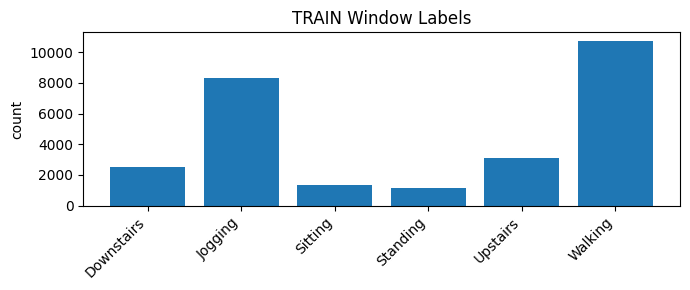


[VAL] 윈도우 라벨 분포:
  Downstairs: 326
  Jogging: 904
  Sitting: 254
  Standing: 174
  Upstairs: 325
  Walking: 1369


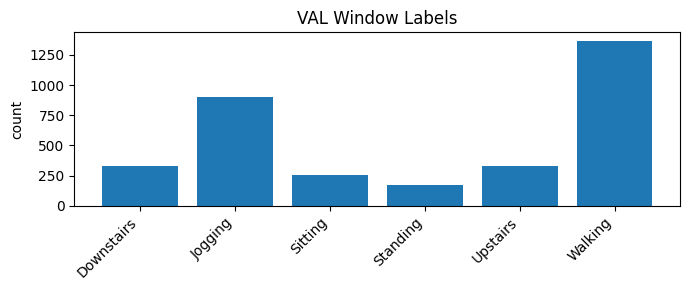


[TEST] 윈도우 라벨 분포:
  Downstairs: 213
  Jogging: 1161
  Sitting: 167
  Standing: 126
  Upstairs: 285
  Walking: 825


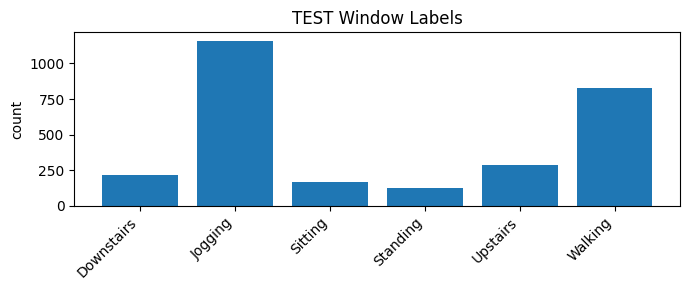

In [14]:
#윈도우 품질/ 분포 점검
print("\n윈도우 결과 확인:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)
print("X_test: ", X_test.shape,  "y_test: ", y_test.shape)

# 윈도우 라벨 분포(학습/검증/테스트)
def show_window_label_dist(name, y_arr, le):
    vc = pd.Series(y_arr).value_counts().sort_index()
    idx2lab = dict(zip(range(len(le.classes_)), le.classes_))
    print(f"\n[{name}] 윈도우 라벨 분포:")
    for k,v in vc.items():
        print(f"  {idx2lab.get(k, k)}: {v}")
    # bar
    plt.figure(figsize=(7,3))
    labels = [idx2lab.get(k, k) for k in vc.index.tolist()]
    plt.bar(labels, vc.values)
    plt.title(f"{name} Window Labels")
    plt.xticks(rotation=45, ha='right'); plt.ylabel('count')
    plt.tight_layout(); plt.show()

show_window_label_dist("TRAIN", y_train, le)
show_window_label_dist("VAL",   y_val,   le)
show_window_label_dist("TEST",  y_test,  le)


In [9]:
# 5) CNN 모델
# --------------------------------------------------------------------
num_classes = len(le.classes_)
input_shape = X_train.shape[1:]

def build_cnn(input_shape, num_classes, dropout=0.3):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv1D(64, 5, padding="same")(inputs); x = layers.BatchNormalization()(x); x = layers.ReLU()(x); x = layers.MaxPool1D(2)(x)
    x = layers.Conv1D(128, 5, padding="same")(x);    x = layers.BatchNormalization()(x); x = layers.ReLU()(x); x = layers.MaxPool1D(2)(x)
    x = layers.Conv1D(256, 3, padding="same")(x);    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(128)(x); x = layers.ReLU()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="wisdm_1dcnn")
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy", keras.metrics.SparseTopKCategoricalAccuracy(k=2, name="top2")]
    )
    return model

model = build_cnn(input_shape, num_classes)
model.summary()


Model: "wisdm_1dcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 128, 64)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 32, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,134 (688.02 KB)

 Trainable params: 175,238 (684.52 KB)

 Non-trainable params: 896 (3.50 KB)

In [10]:
# 6) 학습
# --------------------------------------------------------------------
callbacks = [
    keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor="val_accuracy"),
    keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.5, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 42s 354ms/step - accuracy: 0.7555 - loss: 0.6502 - top2: 0.8807 - val_accuracy: 0.2733 - val_loss: 2.1488 - val_top2: 0.4690 - learning_rate: 0.0010
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 343ms/step - accuracy: 0.9134 - loss: 0.2308 - top2: 0.9818 - val_accuracy: 0.5304 - val_loss: 2.8985 - val_top2: 0.6417 - learning_rate: 0.0010
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 37s 349ms/step - accuracy: 0.9463 - loss: 0.1492 - top2: 0.9893 - val_accuracy: 0.8490 - val_loss: 0.3917 - val_top2: 0.9478 - learning_rate: 0.0010
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 346ms/step - accuracy: 0.9580 - loss: 0.1120 - top2: 0.9938 - val_accuracy: 0.8517 - val_loss: 0.4706 - val_top2: 0.9642 - learning_rate: 0.0010
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 333ms/step - accuracy: 0.9670 - loss: 0.0896 - top2: 0.9949 - val_accuracy: 0.8974 - val_loss: 0.3063 - val_top2: 0.9791 - learning_rate: 0.0010
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 38s 350ms/step 

[TEST] loss=0.9608  acc=0.7854  top2=0.9125

Classification Report
              precision    recall  f1-score   support

  Downstairs       0.61      0.72      0.66       213
     Jogging       1.00      0.67      0.80      1161
     Sitting       0.85      1.00      0.92       167
    Standing       0.60      0.76      0.67       126
    Upstairs       0.45      0.67      0.54       285
     Walking       0.82      0.97      0.89       825

    accuracy                           0.79      2777
   macro avg       0.72      0.80      0.75      2777
weighted avg       0.83      0.79      0.79      2777



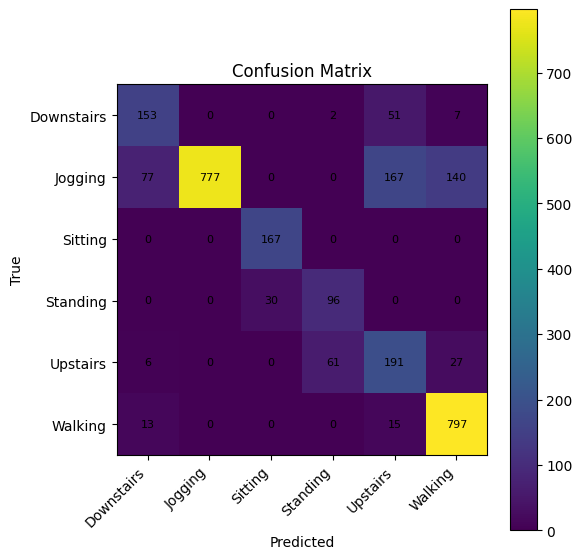

In [11]:
# 7) 평가 + 리포트
# --------------------------------------------------------------------
test_loss, test_acc, test_top2 = model.evaluate(X_test, y_test, verbose=0)
print(f"[TEST] loss={test_loss:.4f}  acc={test_acc:.4f}  top2={test_top2:.4f}")

y_prob = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

print("\nClassification Report")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, interpolation="nearest")
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(num_classes), yticks=np.arange(num_classes),
       xticklabels=le.classes_, yticklabels=le.classes_,
       ylabel="True", xlabel="Predicted", title="Confusion Matrix")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=8)
plt.tight_layout(); plt.show()